<a href="https://colab.research.google.com/github/niranjana2222/Heuristic-for-Classifying-DNA-Strands/blob/main/equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
from numpy.polynomial import polynomial as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from numpy import *
from matplotlib.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits

Read Data

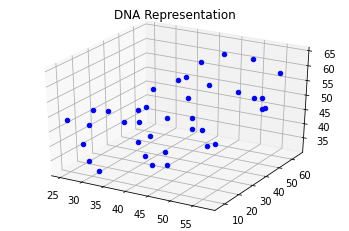

In [ ]:
file = open('/content/1x9n.pdb', 'r')
count = 0
xs = []
ys = []
zs = []

#find x, y, z coordinates of phosphate backbone
while True:
    line = file.readline()
    if not line:
        break
    a = line.split()
    b = 0

    if a[-1] == 'P':
        if a[0] == "ATOM":
            xs.append(a[-6])
            ys.append(a[-5])
            zs.append(a[-4])

"""
print(len(zs))
print(zs)
print(len(ys))
print(ys)
print(len(xs))
print(xs)
"""

#Plot phosphate backbone
fig = plt.figure()
ax = plt.axes(projection='3d')
for x in xs:
    y = ys[xs.index(x)]
    y = float(y)
    z = zs[xs.index(x)]
    z = float(z)
    x = float(x)
    ax.scatter(x, y, z, c = "blue")
ax.set_title("DNA Representation")
plt.show()

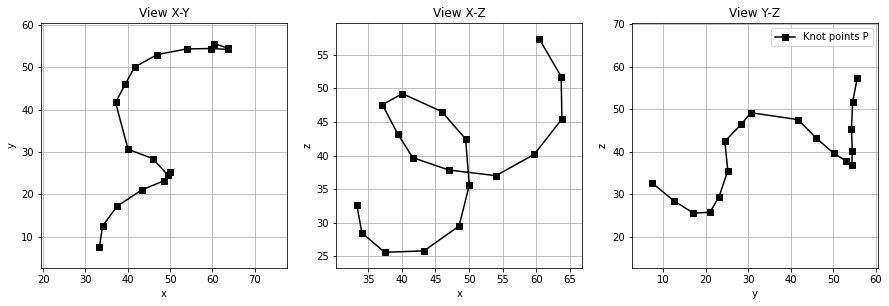

In [ ]:
%matplotlib inline

#Generate y,z coords from given x coords
def generate_yz_coords(x):
    y = -0.5 * x**2 - 0.3 * x + 5
    z = 0.1 * x**3 + 5
    return y, z

#Create matrix P with all coordinates
x = ['33.294', '34.051', '37.454', '43.291', '48.513', '50.025', '49.487', '45.935', '40.075', '37.116', '39.372', '41.620', '46.977', '53.990', '59.700', '63.806', '63.697', '60.418']
y = ['7.422', '12.484', '17.125', '21.004', '23.151', '25.188', '24.494', '28.402', '30.620', '41.689', '45.942', '50.027', '53.007', '54.335', '54.430', '54.229', '54.513', '55.604']
z = ['32.715', '28.522', '25.611', '25.822', '29.513', '35.585', '42.467', '46.551', '49.202', '47.565', '43.243', '39.697', '37.849', '37.008', '40.183', '45.429', '51.749', '57.386']

n = len(x)

P = zeros([n,3])
P[:,0] = x
P[:,1] = y
P[:,2] = z

#Calculate some points to display the generating curve
x_gen = linspace(-2, 2, 50)
y_gen, z_gen = generate_yz_coords(x_gen)
P_gen = zeros([len(x_gen),3])
P_gen[:,0] = x_gen
P_gen[:,1] = y_gen
P_gen[:,2] = z_gen

#--- Plot
f, ax = subplots(1, 3, figsize=(15,4.5))
i = 0
#ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,1], 'ks-', label='Knot points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 1
#ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,2], 'ks-', label='Knot points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 2
#ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,1], P[:,2], 'ks-', label='Knot points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()

In [ ]:
def uniform_param(P):
    u = linspace(0, 1, len(P))
    return u
    
def chordlength_param(P):
    u = generate_param(P, alpha=1.0)
    return u
    
def centripetal_param(P):
    u = generate_param(P, alpha=0.5)
    return u
    
def generate_param(P, alpha):
    n = len(P)
    u = zeros(n)
    u_sum = 0
    for i in range(1,n):
        u_sum += linalg.norm(P[i,:]-P[i-1,:])**alpha
        u[i] = u_sum
    
    return u/max(u)

Find minimum 

In [ ]:
#-------------------------------------------------------------------------------
# Find Minimum by Golden Section Search Method
# Returns x minimizing function f(x) on interval a,b
#-------------------------------------------------------------------------------
def find_min_gss(f, a, b, eps=1e-4):
    
    # Golden section: 1/phi = 2/(1+sqrt(5))
    R = 0.61803399
    
    # Num of needed iterations to get precision eps: log(eps/|b-a|)/log(R)
    n_iter = int(ceil(-2.0780869 * log(eps/abs(b-a))))
    c = b - (b-a)*R
    d = a + (b-a)*R

    for i in range(n_iter):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b-a)*R
        d = a + (b-a)*R

    return (b+a)/2

Iterative parameterization

In [ ]:
def iterative_param(P, u, fxcoeff, fycoeff, fzcoeff, fig_ax):
    
    global iter_i, plt_color
    u_new = u.copy() #stores curve parametric equations
    f_u = zeros(3) #f_u = three parametric equations 

    #Calculate approx. error s(u) related to point P_i
    def calc_s(u):
        f_u[0] = pl.polyval(u, fxcoeff) #pl.polyval(polynomial equation, point x)
        f_u[1] = pl.polyval(u, fycoeff)
        f_u[2] = pl.polyval(u, fzcoeff)

        s_u = linalg.norm(P[i]-f_u) #calculates error of the point and parametric equation 
        return s_u
    
    #Find new values u that locally minimising the approximation error (excl. fixed end-points)
    for i in range(1, len(u)-1):
        
        #--- Find new u_i minimising s(u_i) by Golden search method
        u_new[i] = find_min_gss(calc_s, u[i-1], u[i+1]) #find polynomial equation that minimizes the error
        
        #Plots
        #--- Sample some values bewteen u[i-1] and u[i+1] to plot graph
        u_samp = linspace(u[i-1], u[i+1], 25)
        
        x = pl.polyval(u_samp, fxcoeff)
        y = pl.polyval(u_samp, fycoeff)
        z = pl.polyval(u_samp, fzcoeff)

        residual = P[i] - array([x,y,z]).T
        s_u_samp = [linalg.norm(residual[j]) for j in range(len(u_samp))]
        
        #--- Plot error to given axes
        fig_ax.plot(u_samp, s_u_samp, color=plt_color[iter_i], alpha=plt_alpha)
        fig_ax.plot(u_new[i], calc_s(u_new[i]), 'o', color=plt_color[iter_i], alpha=plt_alpha)
        
    return u_new

Run the function

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming 

0.6711225344836671
0.9727414971920284
0.4857662902663553
0.7098767739806836
hi
0.7193726836442561
0.9869186362301214
0.45475458240388256
0.7203486340927533
hi
0.7350073630903933
0.9866613005492189
0.44380726480567567
0.7218253094817625
hi
0.7401413609719873
0.9859440524175167
0.4430167860177764
0.7230340664690935
hi
0.7424627382089246
0.9856742301956162
0.4438514896327701
0.7239961526791037
hi


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming 

0.7437806473575128
0.9856367304208533
0.4450481037246443
0.7248218271676702
hi
0.7445511087375114
0.9857197141352011
0.44648850389765016
0.7255864422567876
hi
0.7448760286156881
0.985841434371491
0.4483420648201937
0.7263531759357909
hi
0.744878448352926
0.9859746634248585
0.4505462330614224
0.7271331149464023
hi
0.7445792065867273
0.9860963849035865
0.45315893249248207
0.7279448413275986
hi


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming 

0.7439283097486242
0.9862066175243487
0.4562482497117627
0.7287943923282452
hi
0.7430086311185459
0.9863079111679476
0.4597072252852593
0.7296745891905841
hi
0.74177617889689
0.9863842494827307
0.463646215244348
0.7306022145413228
hi
0.7402767200162215
0.9864416631122033
0.46798990002905727
0.7315694277191606
hi
0.7384667479854561
0.9864971894504057
0.47274467352726923
0.7325695369877102
hi


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming 

0.7364082874248836
0.986525127003043
0.4779361716923415
0.7336231953734226
hi
0.7340993161384521
0.9865430850061067
0.48351528287225354
0.7347192280056042
hi
0.731484351804081
0.9865479040525998
0.4895618893012268
0.7358647150526357
hi
0.7286948433353644
0.986548820822277
0.49589051474027035
0.737044726299304
hi
0.7256586495270059
0.9865270644402654
0.5026575646756979
0.7382810928809898
hi


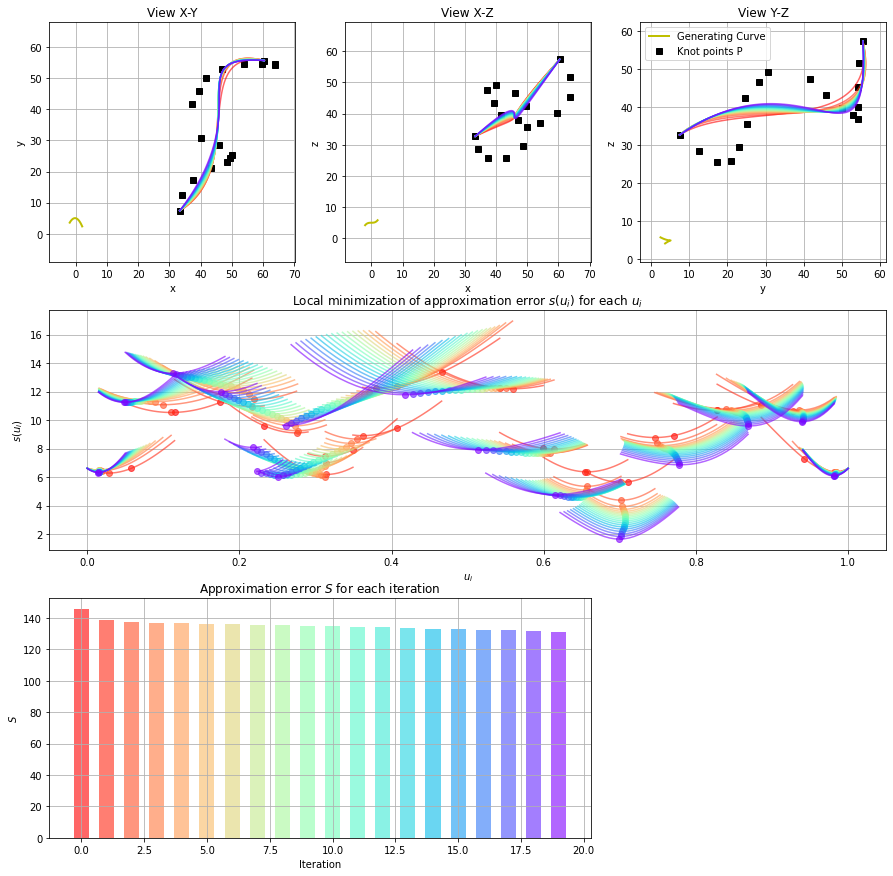

In [ ]:
%matplotlib inline

from sklearn.metrics import r2_score

#-------------------------------------------------------------------------------
# Options for the approximation method
#-------------------------------------------------------------------------------
polydeg = 3           # Degree of polygons of parametric curve (3 coordinates)
w = ones(n)           # Set weights for knot points (n=number of knot points)
w[0] = w[-1] = 1e6    # Weights for 1st and last point to 1e6
max_iter = 20         # Max. number of iterations
eps = 1e-3            # learning rate

plt_alpha = 0.6
plt_color = cm.rainbow(linspace(1,0,max_iter))

#-------------------------------------------------------------------------------
# Init variables
#-------------------------------------------------------------------------------
f_u = zeros([n,3]) #creates 3 parametric equations
uu = linspace(0,1,100) #for plotting
f_uu = zeros([len(uu),3]) #for plotting
S_hist = []
ax = [None]*5 #for plotting

#-------------------------------------------------------------------------------
# Init figures
#-------------------------------------------------------------------------------
fig = figure(figsize=(15,15))
figshape = (3,3)

ax[0] = subplot2grid(figshape, loc=(0,0))
ax[1] = subplot2grid(figshape, loc=(0,1))
ax[2] = subplot2grid(figshape, loc=(0,2))
ax[3] = subplot2grid(figshape, loc=(1,0), colspan=3)
ax[4] = subplot2grid(figshape, loc=(2,0), colspan=2)
i = 0
ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,1], 'ks', label='Knot points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 1
ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,2], 'ks', label='Knot points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 2
ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,1], P[:,2], 'ks', label='Knot points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()
i = 3
ax[i].set_title('Local minimization of approximation error $s(u_i)$ for each $u_i$')
ax[i].set_xlabel('$u_i$'); ax[i].set_ylabel('$s(u_i)$');
ax[i].grid()
i = 4
ax[i].set_title('Approximation error $S$ for each iteration')
ax[i].set_xlabel('Iteration'); ax[i].set_ylabel('$S$');
ax[i].grid()

#-------------------------------------------------------------------------------
# Compute the iterative approximation
#-------------------------------------------------------------------------------
for iter_i in range(max_iter):

    #--- Initial or iterative parametrization
    if iter_i == 0:
        #u = uniform_param(P)
        #u = chordlength_param(P)
        u = centripetal_param(P)
    else:
        u = iterative_param(P, u, fxcoeff, fycoeff, fzcoeff, ax[3])
        #P = knot points (3D matrix)
        #u = parametric equation
        #fxcoeff = coeffs for parametric equations
        #ax
    
    #--- Compute polynomial approximations and get their coefficients
    fxcoeff = pl.polyfit(u, P[:,0], polydeg, w=w) #polyfit(equation, x coordinates, degree of polynomial, weights)
    fycoeff = pl.polyfit(u, P[:,1], polydeg, w=w) 
    fzcoeff = pl.polyfit(u, P[:,2], polydeg, w=w)
    
    #--- Calculate function values f(u)=(fx(u),fy(u),fz(u))
    f_u[:,0] = pl.polyval(u, fxcoeff)
    f_u[:,1] = pl.polyval(u, fycoeff)
    f_u[:,2] = pl.polyval(u, fzcoeff)

    #calculate r score
    x2 = r2_score(x,f_u[:,0])
    y2 = r2_score(y,f_u[:,1])
    z2 = r2_score(z,f_u[:,2])
    print(x2)
    print(y2)
    print(z2)
    print((x2+y2+z2)/3.0)
    print("hi")
    
    #--- Calculate fine values for ploting
    f_uu[:,0] = pl.polyval(uu, fxcoeff)
    f_uu[:,1] = pl.polyval(uu, fycoeff)
    f_uu[:,2] = pl.polyval(uu, fzcoeff)

    #--- Print plots
    hp = ax[0].plot(f_uu[:,0], f_uu[:,1], color=plt_color[iter_i], alpha=plt_alpha)
    hp = ax[1].plot(f_uu[:,0], f_uu[:,2], color=plt_color[iter_i], alpha=plt_alpha)
    hp = ax[2].plot(f_uu[:,1], f_uu[:,2], color=plt_color[iter_i], alpha=plt_alpha)
    
    #--- Errors of init parametrization
    if iter_i == 0:
        for i in range(1, len(u)-1):
            ax[3].plot(u[i], linalg.norm(P[i]-f_u[i]), 'o', color=plt_color[iter_i], alpha=plt_alpha)
    
    #--- Total error of approximation S for iteration i
    S = 0
    for j in range(len(u)):
        S += w[j] * linalg.norm(P[j] - f_u[j])
    
    #--- Add bar of approx. error
    ax[4].bar(iter_i, S, width=0.6, color=plt_color[iter_i], alpha=plt_alpha)
    S_hist.append(S)
    
    #--- Stop iterating if change in error is lower than desired condition
    if iter_i > 0:
        S_change = S_hist[iter_i-1] / S_hist[iter_i] - 1
        #print('iteration:%3i, approx.error: %.4f (%f)' % (iter_i, S_hist[iter_i], S_change))
        if S_change < eps:
            break

In [ ]:
print(u)
print(fxcoeff)
print(fycoeff)
print(fzcoeff)

[0.         0.01465109 0.04853482 0.11284418 0.17523958 0.21737627
 0.2230177  0.2512581  0.26168841 0.41728265 0.51404054 0.61531384
 0.69937507 0.77804304 0.86891461 0.93953601 0.98116941 1.        ]
[  33.294        77.21152724 -156.85114047  106.76361323]
[  7.422      101.73161637 -54.18129449   0.63167812]
[  32.715        70.17025608 -184.39166124  138.89240516]


In [ ]:

#caluclate midpoint
max_x = 0
min_x = 100000000000

max_y = 0
min_y = 100000000000

max_z = 0
min_z = 100000000000

def find_min(x, min, max):
  for a in x: 
    temp = int(a)
    if max < temp:
      max = temp
    elif min > temp:
      min = temp

mid_x = (max_x+min_x)/2
mid_y = (max_y+min_y)/2
mid_z = (max_z+min_z)/2

point_x = [pl.polyval(mid_x, fxcoeff)]
point_y = [pl.polyval(mid_y, fycoeff)]
point_z = [pl.polyval(mid_z, fzcoeff)]

Using matplotlib backend: agg


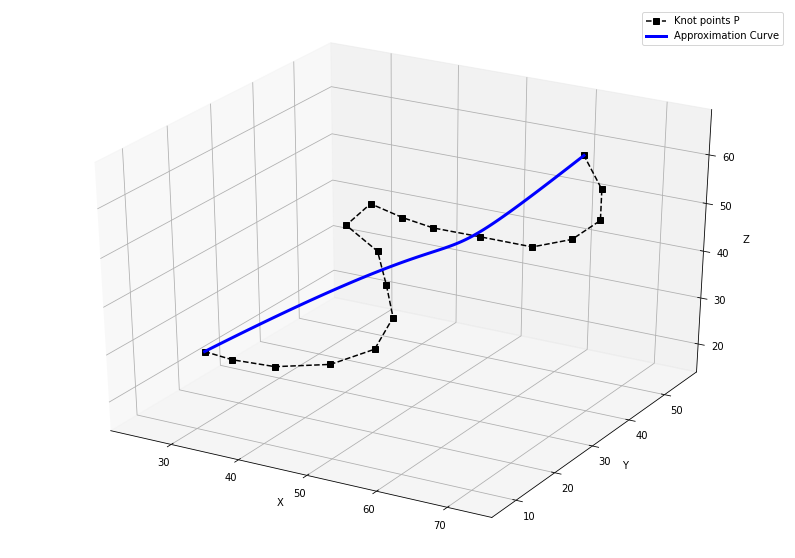

In [ ]:
%matplotlib

#-------------------------------------------------------------------------------
# - Make axes of 3D plot to have equal scales
# - This is a workaround to Matplotlib's set_aspect('equal') and axis('equal')
#   which were not working for 3D
#-------------------------------------------------------------------------------
def set_axes_equal_3d(ax):
    limits = array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    spans = abs(limits[:,0] - limits[:,1])
    centers = mean(limits, axis=1)
    radius = 0.5 * max(spans)
    ax.set_xlim3d([centers[0]-radius, centers[0]+radius])
    ax.set_ylim3d([centers[1]-radius, centers[1]+radius])
    ax.set_zlim3d([centers[2]-radius, centers[2]+radius])

#--- 3D Plot
fig = figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1,projection='3d')

#ax.plot(*P_gen.T, color='y', lw=4, label='Generating Curve')
ax.plot(*P.T, color='k', ls='--', marker='s', label='Knot points P')
ax.plot(*f_uu.T, color='b', ls='-', lw=3, label='Approximation Curve')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
#ax.set_aspect('equal', 'datalim')
set_axes_equal_3d(ax)